# 1. setup

## 1.1. libraries

In [1]:
import sys
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cvxpy as cp
import matplotlib.colors as mcolors

from helper_plot import *

<helper_plot> version: 3.7.4 (default, Feb  5 2024, 10:39:00) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-39)]


## 1.2. variables

In [6]:
path_project = '../'
path_mat_PC_train = f'{path_project}data/mat_PC/train/'
path_mat_PC_test = f'{path_project}data/mat_PC/test/'
path_label = f'{path_project}data/label/'
path_population = f'{path_project}data/population/'

n_PC = 600
n_train = 2560
n_test = 641
n_subpop = 26

mat_GT_train = np.loadtxt(f'{path_mat_PC_train}mat_PC_train.tsv', delimiter = '\t')[:, 0:n_PC]
mat_GT_test = np.loadtxt(f'{path_mat_PC_test}mat_PC_test_full.tsv', delimiter = '\t')[0:n_PC, :]
mat_GT_test = np.transpose(mat_GT_test)

vec_label_train_index = np.loadtxt(f'{path_label}index_train.csv', delimiter = ',')
vec_label_train_index = vec_label_train_index.astype(int) - 4
vec_label_test_index = np.loadtxt(f'{path_label}index_test.csv', delimiter = ',')
vec_label_test_index = vec_label_test_index.astype(int) - 4

vec_class = pd.read_csv(f'{path_population}population.tsv', delimiter = '\t', header = None)
vec_class = np.array(vec_class.values).flatten()

df_label = pd.read_csv(f'{path_population}meta_merged.csv', delimiter = ',')

vec_label_test = [df_label['SUP'][i] for i in vec_label_test_index]
vec_label_train = [df_label['SUP'][i] for i in vec_label_train_index]

dict_mean_GT_subpop = {}
mat_mean_GT_subpop = np.zeros([n_PC, 26])
for i, cls in enumerate(vec_class):
    vec_index_subpop = [i for i in range(n_train) if vec_label_train[i] == cls]
    mat_mean_GT_subpop[:, i] = sum(mat_GT_train[vec_index_subpop, :]) / len(vec_index_subpop)
    dict_mean_GT_subpop[cls] = mat_mean_GT_subpop[:, i]

## 1.3. functions

In [15]:
def pred_convex(vec_test, label_test, mat_mean_GT_subpop):
    # Define the optimization variable
    X = cp.Variable(n_subpop)

    # Define the objective function (minimize the least squares error)
    objective = cp.Minimize(cp.norm(mat_mean_GT_subpop @ X - vec_test, 'fro'))

    # Define the constraints
    constraints = [X >= 0, cp.sum(X) == 1]

    # Define and solve the problem
    problem = cp.Problem(objective, constraints)
    problem.solve()

    result_pred = X.value
    result_pred_subpop = vec_class[np.argmax(result_pred)]
    
    # Use result_pred to construct a n_PC-dimensional vector made from linear combinations of the mean vectors
    result_pred_PC = mat_mean_GT_subpop @ result_pred

    mean_PC_subpop = dict_mean_GT_subpop[label_test]

    # Compute the cosine similarity between result_pred_PC and vec_test
    cos_sim = np.dot(result_pred_PC, vec_test) / (np.linalg.norm(result_pred_PC) * np.linalg.norm(vec_test))
    
    # Compute the cosine similarity between mean_PC_subpop and vec_test
    cos_sim_subpop = np.dot(mean_PC_subpop, vec_test) / (np.linalg.norm(mean_PC_subpop) * np.linalg.norm(vec_test))

    bool_correct = (result_pred_subpop == label_test)

    return result_pred, result_pred_subpop, cos_sim, cos_sim_subpop, bool_correct

def cossim_subpop(vec_test, label_test):
    
    mean_PC_subpop = dict_mean_GT_subpop[label_test]
    
    # Compute the cosine similarity between mean_PC_subpop and vec_test
    cos_sim_subpop = np.dot(mean_PC_subpop, vec_test) / (np.linalg.norm(mean_PC_subpop) * np.linalg.norm(vec_test))

    return cos_sim_subpop

def darken_color(base_color, factor):
    rgb = mcolors.hex2color(base_color)
    """Darken an RGB color by a given factor."""
    result_rgb = tuple(max(0, channel * factor) for channel in rgb)
    return mcolors.rgb2hex(result_rgb)

def lighten_color(base_color, factor):
    rgb = mcolors.hex2color(base_color)
    """Lighten an RGB color by a given factor."""
    result_rgb = tuple(min(1, channel + (1 - channel) * factor) for channel in rgb)
    return mcolors.rgb2hex(result_rgb)

# 2. convex optimization and angle computations

# 2.1. data process

In [11]:
df_result_subpop = np.zeros([n_test, 2])
df_result_subpop = pd.DataFrame(df_result_subpop)

for index_test in range(n_test):
    cossim_subpop(mat_GT_test[index_test, :], vec_label_test[index_test])
df_result = np.zeros([n_test, 5])
df_result = pd.DataFrame(df_result)

for index_test in range(n_test):
    # print(f'done with iteration {index_test}')
    result_pred, result_pred_subpop, cos_sim, cos_sim_subpop, bool_correct = pred_convex(mat_GT_test[index_test, :], vec_label_test[index_test], mat_mean_GT_subpop)
    df_result.iloc[index_test, :] = [vec_label_test[index_test], result_pred_subpop, bool_correct, cos_sim, cos_sim_subpop]

df_result_output = df_result.copy()
df_result = df_result_output.copy()
df_result.columns = ['test_label_true', 'test_label_predicted', 'bool_correct', 'cos_sim', 'cos_sim_subpop']
df_result['test_label_true_int'] = [np.where(vec_class == class_i)[0][0] + 1 for class_i in df_result['test_label_true']]
df_result['marker'] = df_result['bool_correct'].map({True: 'o', False: 'x'})

### 2.1.1. adding color

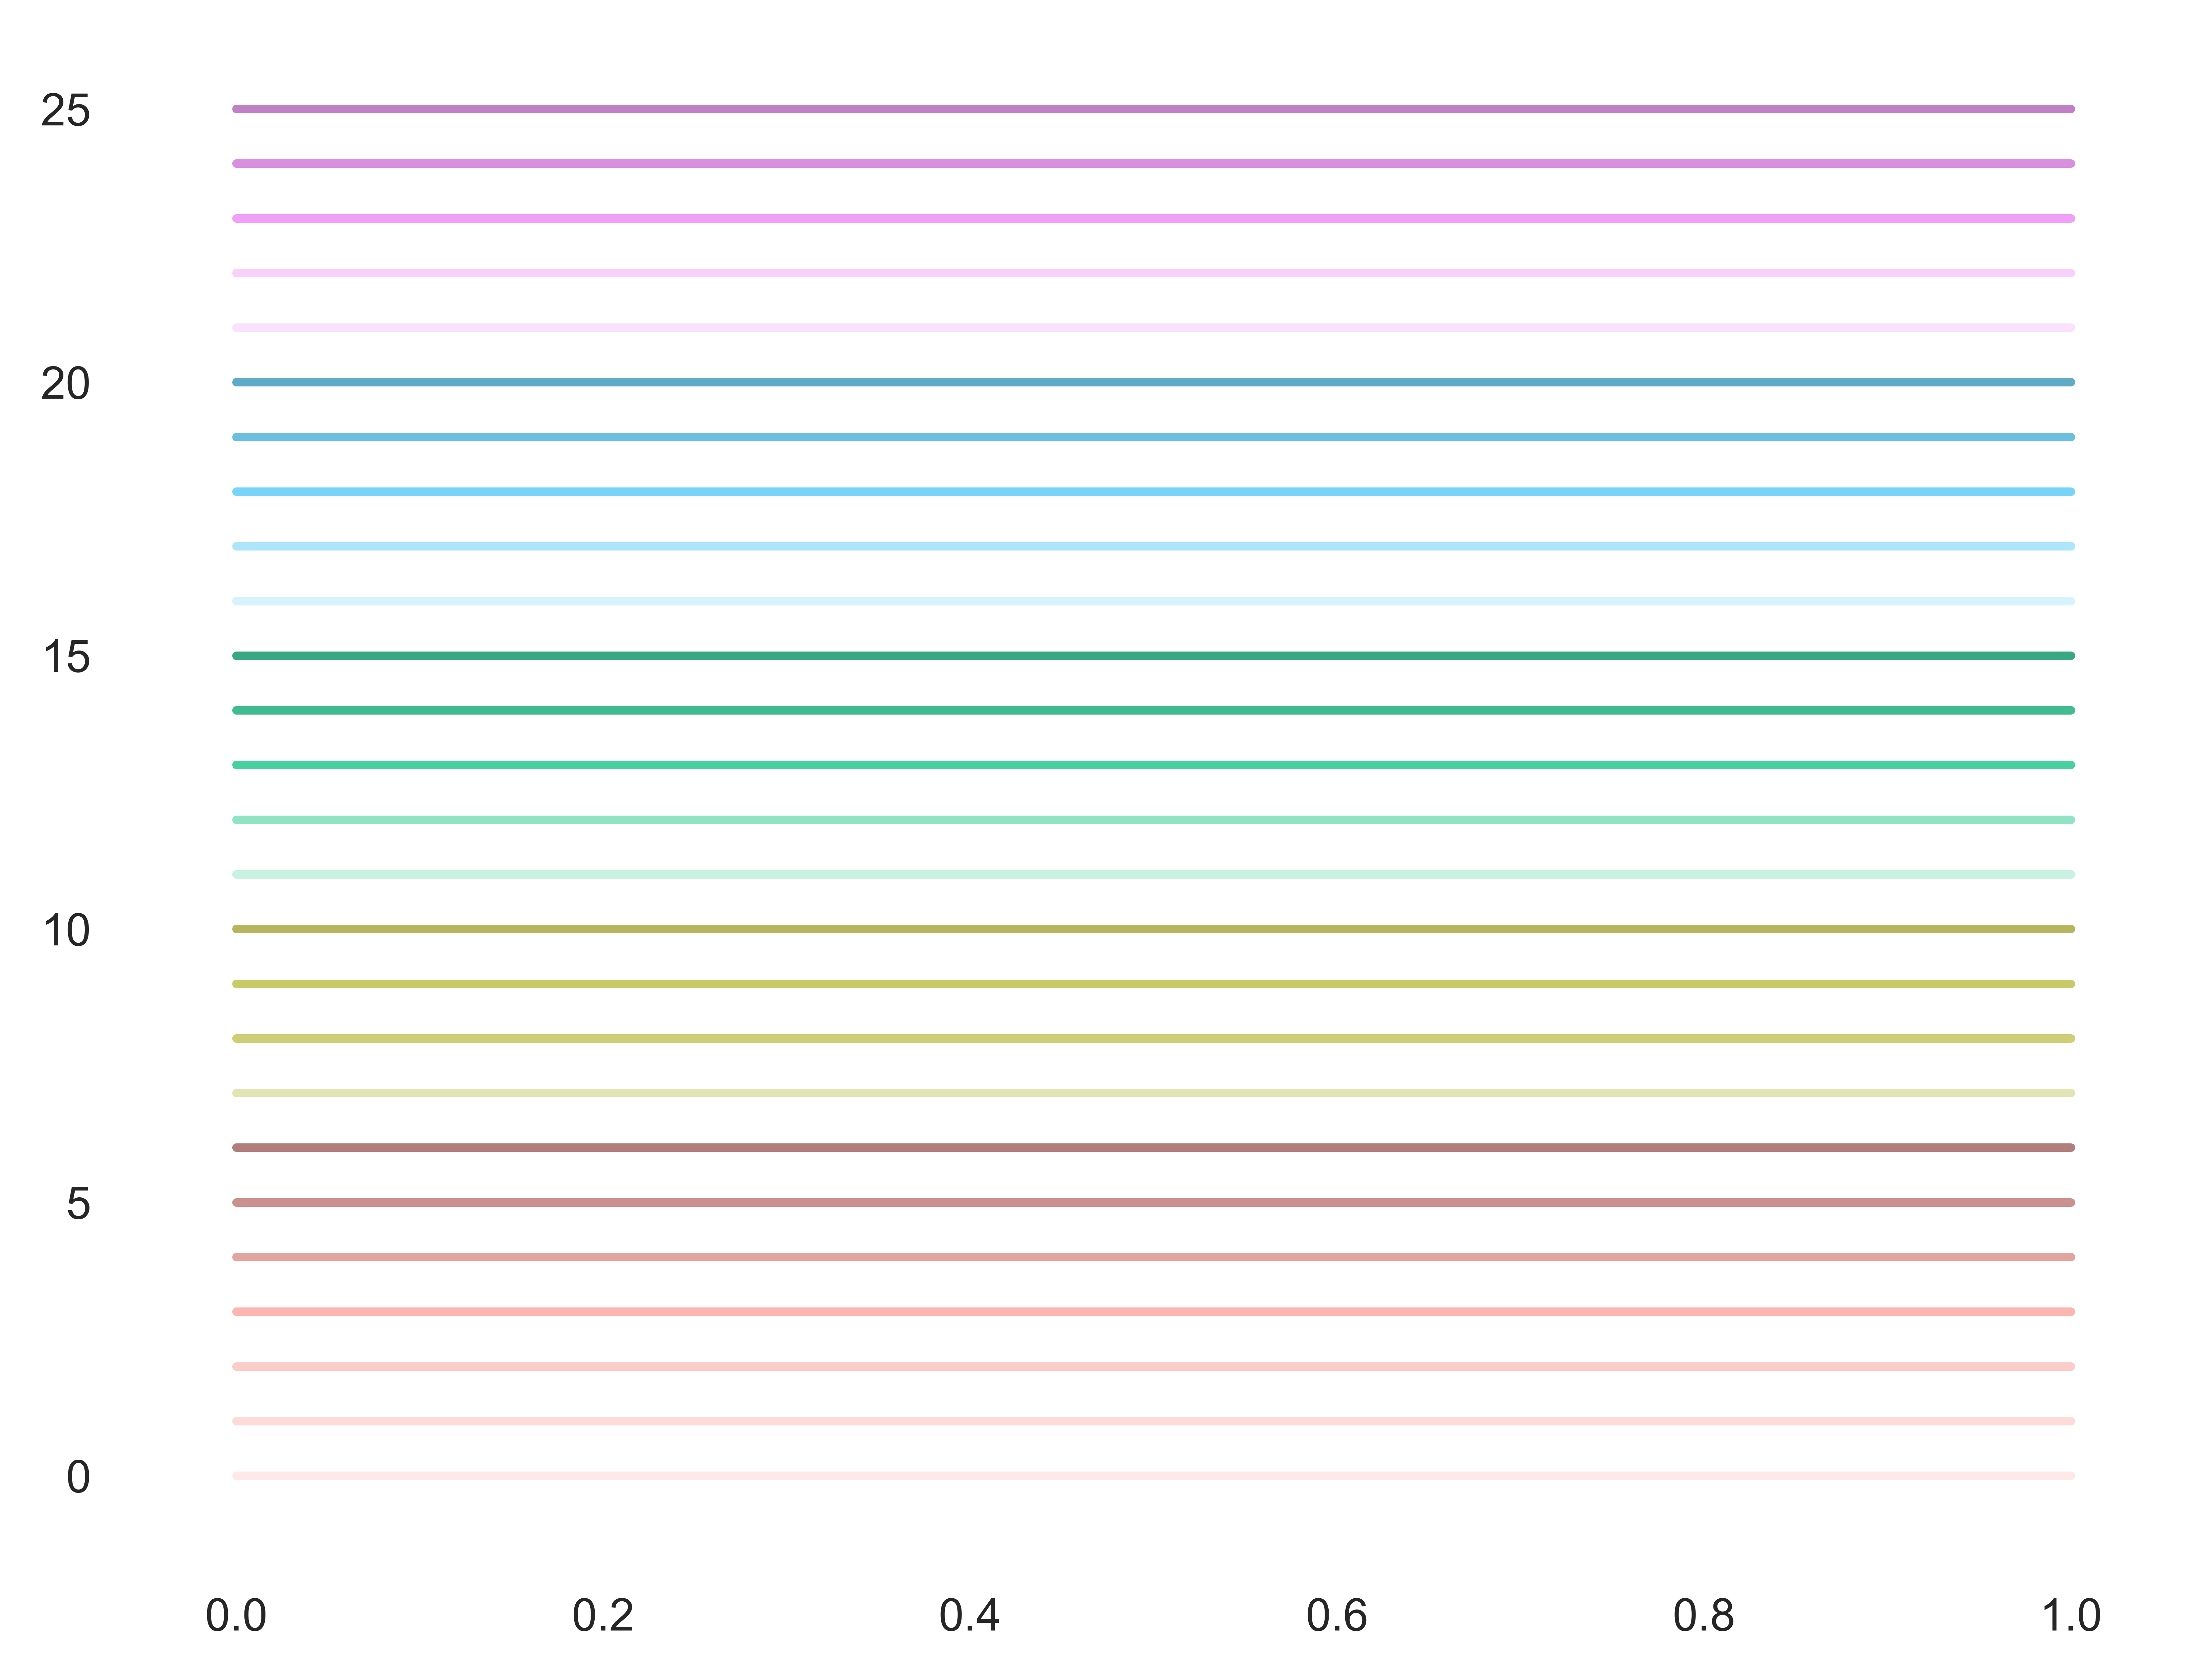

In [22]:
# AFR
base_color = dict_color_super['AFR']
colors_AFR = [lighten_color(base_color, 0.7),
              lighten_color(base_color, 0.5),
              lighten_color(base_color, 0.3),
              base_color,
              darken_color(base_color, 0.9),
              darken_color(base_color, 0.8),
              darken_color(base_color, 0.7)]

# AMR
base_color = dict_color_super['AMR']
colors_AMR = [lighten_color(base_color, 0.5), 
              lighten_color(base_color, 0.1), 
              base_color, 
              darken_color(base_color, 0.9)]

# EAS
base_color = dict_color_super['EAS']
colors_EAS = [lighten_color(base_color, 0.7), 
              lighten_color(base_color, 0.4), 
              base_color, 
              darken_color(base_color, 0.9), 
              darken_color(base_color, 0.8)]

# EUR
base_color = dict_color_super['EUR']
colors_EUR = [lighten_color(base_color, 0.7), 
              lighten_color(base_color, 0.4), 
              base_color, 
              darken_color(base_color, 0.9), 
              darken_color(base_color, 0.8)]

# SAS
base_color = dict_color_super['SAS']
colors_SAS = [lighten_color(base_color, 0.7), 
              lighten_color(base_color, 0.5), 
              base_color, 
              darken_color(base_color, 0.9), 
              darken_color(base_color, 0.8)]

colors = colors_AFR + colors_AMR + colors_EAS + colors_EUR + colors_SAS
for i in range(n_subpop):
    plt.plot([0, 1], [i, i], color=colors[i], label=f'Color {i}')
    
# colors
dict_color_subpop = {}
for i, cls in enumerate(vec_class):
    dict_color_subpop[cls] = colors[i]

df_result['color'] = [dict_color_subpop[cls_i] for cls_i in df_result['test_label_true']]

# colors_AFR + colors_AMR + colors_EAS + colors_EUR + colors_SAS
dict_color_subpop = {}
for i, cls in enumerate(vec_class):
    dict_color_subpop[cls] = colors[i]

## 2.2. figure 2 plot

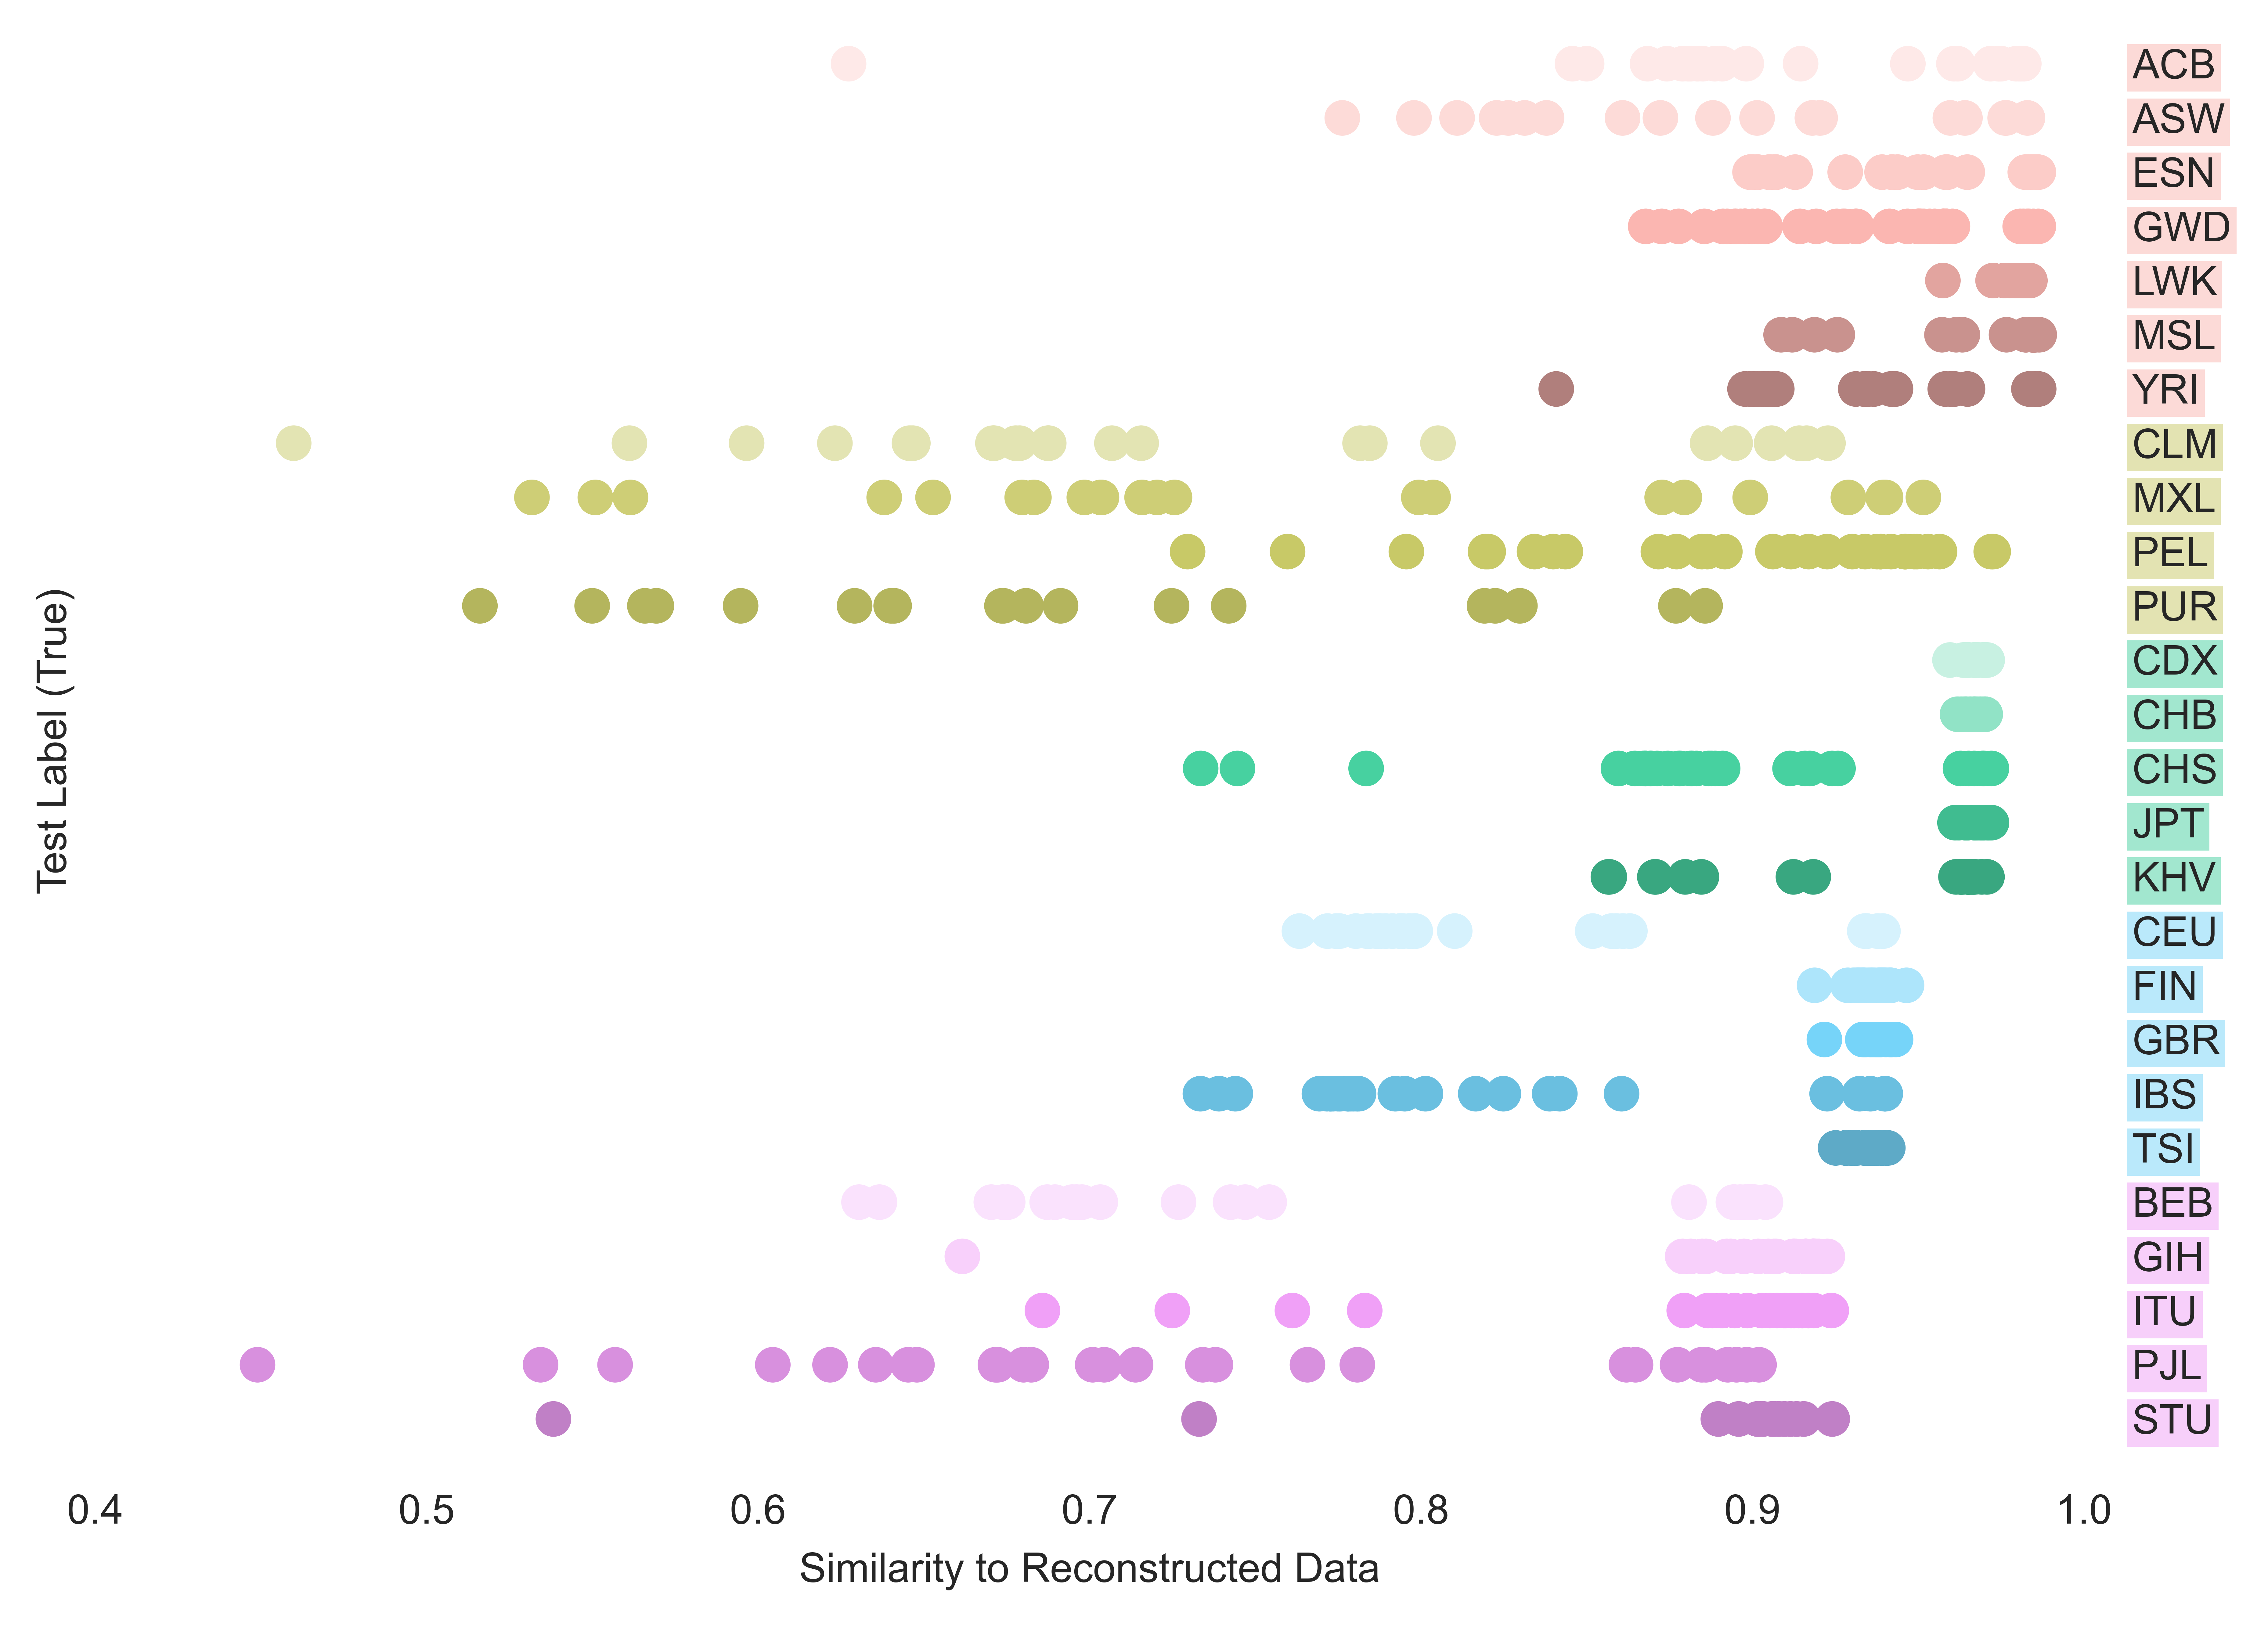

In [23]:
fig, ax = plt.subplots(figsize=(size_twocolumn, 5))
plt.style.use('default')
ax.scatter(df_result['cos_sim'], 
           27 - df_result['test_label_true_int'], # reverse the order of vec_class
           marker='o', color=df_result['color'])
    
# Set labels and title
ax.set_ylabel('Test Label (True)', fontsize = size_font_medium)
ax.set_xlabel('Similarity to Reconstructed Data', fontsize = size_font_medium)
#ax.set_title('Cosine Similarity Between Test Data PCs and Reconstructed Data', fontsize = size_font_medium)
ax.set_xlim(0.4, 1)
ax.set_ylim(0.5, n_subpop + 0.5)

# Set ticks for y-axis on the right side
ax.yaxis.tick_right()

# Set ticks for x-axis
ax.set_yticks(range(1, n_subpop + 1))

# reverse the order of vec_class
ax.set_yticklabels(vec_class[::-1], fontsize = size_font_medium, ha = "left")

ax.xaxis.set_tick_params(labelsize = size_font_medium)

# Remove tick marks on the y-axis
ax.tick_params(axis='y', right=False)

for label_i in (ax.get_yticklabels()):
    pop_temp = label_i.get_text()
    color_temp = dict_color_super[df_meta_unique[df_meta_unique['SUP'] == pop_temp]['POP'].values[0]]
    label_i.set_bbox(dict(facecolor = color_temp, 
                        edgecolor='None', 
                        alpha = 0.5, 
                        pad = 1))

plt.savefig(path_plot + 'figure2/figure2b_cossim_by_group.pdf', format = 'pdf', dpi = 1200)

# Show plot
plt.show()

## 2.3. s.figure 3

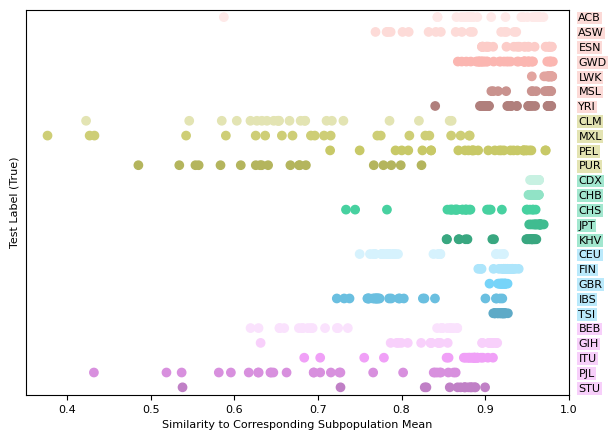

In [24]:
fig, ax = plt.subplots(figsize=(size_twocolumn, 5))

ax.scatter(df_result['cos_sim_subpop'], 
           27 - df_result['test_label_true_int'], # reverse the order of vec_class
           marker='o', color=df_result['color'])
    
# Set labels and title
ax.set_ylabel('Test Label (True)', fontsize = size_font_medium)
ax.set_xlabel('Similarity to Corresponding Subpopulation Mean', fontsize = size_font_medium)
#ax.set_title('Cosine Similarity Between Test Data PCs and Reconstructed Data', fontsize = size_font_medium)
ax.set_xlim(0.35, 1)
ax.set_ylim(0.5, n_subpop + 0.5)

# Set ticks for y-axis on the right side
ax.yaxis.tick_right()

# Set ticks for x-axis
ax.set_yticks(range(1, n_subpop + 1))

# reverse the order of vec_class
ax.set_yticklabels(vec_class[::-1], fontsize = size_font_medium, ha = "left")

ax.xaxis.set_tick_params(labelsize = size_font_medium)

# Remove tick marks on the y-axis
ax.tick_params(axis='y', right=False)

for label_i in (ax.get_yticklabels()):
    pop_temp = label_i.get_text()
    color_temp = dict_color_super[df_meta_unique[df_meta_unique['SUP'] == pop_temp]['POP'].values[0]]
    label_i.set_bbox(dict(facecolor = color_temp, 
                        edgecolor='None', 
                        alpha = 0.5, 
                        pad = 1))

plt.savefig(path_plot + 'sfigure3/figure3_cossim_to-corresponding-mean_by_group.pdf', format = 'pdf', dpi = 1200)

# Show plot
plt.show()